# OpenET SIMS
## Collection "Overpass" Examples

In [1]:
import datetime
import pprint

import ee
import pandas as pd

from IPython.display import Image
import openet.sims as model

ee.Initialize()

In [2]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

### Input parameters

In [3]:
collections = ['LANDSAT/LC08/C01/T1_SR']

etr_source = 'projects/climate-engine/cimis/daily'
etr_band = 'ETo'
# etr_source = 'IDAHO_EPSCOR/GRIDMET'
# etr_band = 'eto'

# Date range you want to aggregate ET over
# End date is inclusive (like filterDate() calls)
start_date = '2017-06-01'
end_date = '2017-09-01'

# Only keep images with an average cloud cover less than
# Cloud cover filter parameter is not being passed in (yet)
cloud_cover = 70

# Number of extra days (at start and end) to include in interpolation
interp_days = 32
# Interpolation method - currently only LINEAR is supported
interp_method = 'LINEAR'

test_point = ee.Geometry.Point(-121.5265, 38.7399)
study_area = ee.Geometry.Rectangle(-122.00, 38.50, -121.00, 39.0)

# Hard code the study area and CRS
study_region = study_area.bounds(1, 'EPSG:4326').coordinates().getInfo()
study_crs = 'EPSG:32610'

### Landsat 8 Collection 1 SR Image Collection

In [4]:
model_obj = model.Collection(
    collections=collections,
    etr_source=etr_source, 
    etr_band=etr_band,
    start_date=start_date,
    end_date=end_date,
    geometry=test_point,
    cloud_cover_max=70,
    # filter_args={},
)
pprint.pprint(model_obj.get_image_ids())

['LANDSAT/LC08/C01/T1_SR/LC08_044033_20170614',
 'LANDSAT/LC08/C01/T1_SR/LC08_044033_20170630',
 'LANDSAT/LC08/C01/T1_SR/LC08_044033_20170716',
 'LANDSAT/LC08/C01/T1_SR/LC08_044033_20170801',
 'LANDSAT/LC08/C01/T1_SR/LC08_044033_20170817']


In [5]:
def get_region_df(info):
    """Convert the output of getRegions to a pandas dataframe"""
    col_dict = {}
    info_dict = {}
    for i, k in enumerate(info[0][4:]):
        col_dict[k] = i+4
        info_dict[k] = {}
        
    for row in info[1:]:
        date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')
        for k, v in col_dict.items():
            info_dict[k][date] = row[col_dict[k]]
            
    return pd.DataFrame.from_dict(info_dict)

## "Overpass" Collection

In [6]:
overpass_coll = model_obj.overpass(variables=['ndvi', 'et', 'etr', 'etf'])

In [7]:
overpass_df = get_region_df(overpass_coll.getRegion(test_point, scale=30).getInfo())
pprint.pprint(overpass_df)
print('')
pprint.pprint(overpass_df[['et', 'etr']].sum())

                ndvi        et       etr       etf
2017-06-14  0.024194  6.751514  6.430014  1.050000
2017-06-30  0.555556  5.431988  7.228809  0.751436
2017-07-16  0.874393  7.988128  7.685184  1.039419
2017-08-01  0.866150  7.618535  7.368639  1.033913
2017-08-17  0.879440  6.465323  6.200324  1.042740

et     34.255488
etr    34.912968
dtype: float64


### NDVI

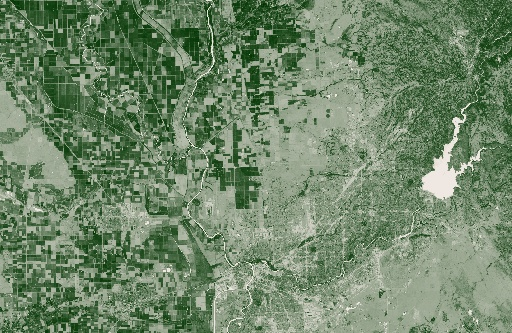

In [8]:
Image(url=ee.Image(overpass_coll.select(['ndvi']).mean())\
          .reproject(crs=study_crs, scale=30)\
          .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 'region': study_region}),
      embed=True, format='png')

### ET fraction

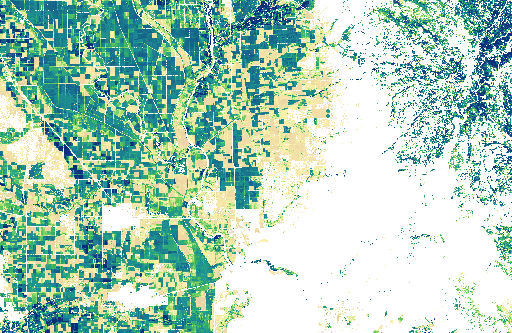

In [9]:
Image(url=ee.Image(overpass_coll.select(['etf']).mean())\
          .reproject(crs=study_crs, scale=30)\
          .getThumbURL({'min': 0.0, 'max': 1.2, 'palette': et_palette, 'region': study_region}),
      embed=True, format='png')

### Reference ET (from CIMIS)

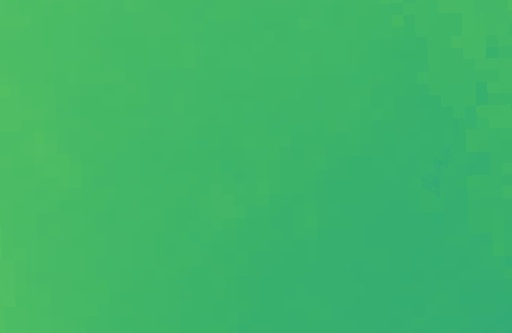

In [10]:
Image(url=ee.Image(overpass_coll.select(['etr']).mean())\
          .reproject(crs=study_crs, scale=30)\
          .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 'region': study_region}),
      embed=True, format='png')

### ET

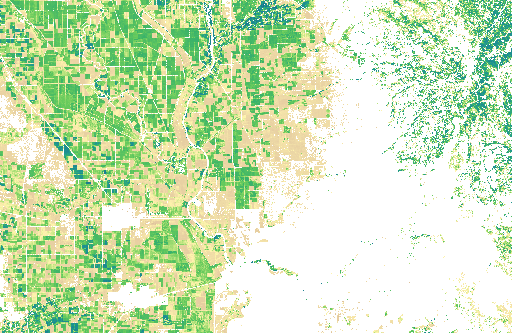

In [11]:
Image(url=ee.Image(overpass_coll.select(['et']).mean())\
          .reproject(crs=study_crs, scale=30)\
          .getThumbURL({'min': 0.0, 'max': 12, 'palette': et_palette, 'region': study_region}),
      embed=True, format='png')